# Neural Network Quantisation

## Preperation: Load Trained Network Data

In [65]:
import numpy as np
import keras
import torch
import matplotlib.pyplot as plt


import NeuralNetwork.NN as NN
import NeuralNetwork.Reader as Reader
import NeuralNetwork.Util
import NeuralNetwork.NN.Quant as nnquant
from NeuralNetwork.Util import plot_network_parameter_histogram

In [66]:
keras_save_dir = '../net/keras'
torch_save_dir = '../net/torch'
mnist_data_dir = 'test/MNIST'
nn_save_dir = 'test/lenet'

keras_lenet = NeuralNetwork.Util.open_keras_model(save_dir=keras_save_dir)

# Initialise a data reader
data_loader = Reader.MnistDataDownloader(folder_path=mnist_data_dir)
path_img, path_lbl = data_loader.get_path(dataset_type=Reader.DataSetType.TRAIN)
reader = Reader.MnistDataReader(image_filename=path_img, label_filename=path_lbl)

Init idx to numpy converter
Number of Images 60000
Number of Rows 28
Number of Columns 28
File closed


In [67]:
# Load our pretrained network
nn_lenet_f64 = NN.Network.LeNet.load_from_files(save_dir=nn_save_dir)
nn_lenet_f64.layers

## Inference with Floating Point


In [68]:
# Get exactly one batch
(lbls, imgs) = next(reader.get_next(batch_size=1))
imgs_float = imgs.astype(dtype=np.float) / 256
lbls_keras = keras_lenet(inputs=imgs_float)
lbls_keras.numpy().argmax(axis=1)

array([5])

In [69]:
lbls_nn_f64, nnf64_activations = nn_lenet_f64.forward_intermediate(imgs_float)
lbls_nn_f64.argmax(axis=1)

array([5])

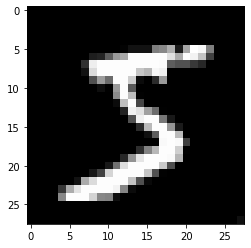

In [70]:
plt.imshow(imgs[0,:,:], cmap="gray")
plt.show()

## Quantisation

Full network quantisation

In [71]:
INT_MAX_VAL = 2**10

nn_lenet_i32 = nn_lenet_f64.quantize_network(new_dtype=np.int32, min_value=-INT_MAX_VAL, max_value=INT_MAX_VAL)
nn_lenet_i32.layers[1].kernel

array([[[[ -406345,   100576,   261211,   562666,  -456408,   541952,
          -1129670,   264994,   331057,   562934,   103198,   376792,
            246705,  -302121,   277006,  -512116]],

        [[  518637,   526918,   663573,   578568, -1091820,  -159937,
          -1094346,   186488,  -737166,   326568,   -49874,    -8331,
           -200971,   632353,  -442157,  -321881]],

        [[  551267,   416237,   -79887,   858339,  -126657,    77291,
            -99293,   -18697, -1497819,   393163,   603556,  -367483,
            306325,   198493,  -657128,   469740]]],


       [[[  148731,   548876,   363272,   280396,   265328,   268121,
           -372631,  -160318,   756153,  -226667,   204246,   112636,
            252926,   656096,   679052,  -910785]],

        [[  602792,   469150,   -35804,  -177140,  -234932,   439579,
            429862,   466718,   388680,   474375,   134410,   646491,
            780878,   258721,   165978,  -102973]],

        [[  602422,  -465094,   5

In [72]:
# Also convert images to integer data
imgs_i8 = nnquant.quantize_vector(imgs_float, target_type=np.int8, max_value=INT_MAX_VAL, min_value=-INT_MAX_VAL,
                                  signed=False)
imgs_i16 = nnquant.quantize_vector(imgs_float, target_type=np.int16, max_value=INT_MAX_VAL, min_value=-INT_MAX_VAL,
                                   signed=False)
imgs_i32 = nnquant.quantize_vector(imgs_float, target_type=np.int32, max_value=INT_MAX_VAL, min_value=-INT_MAX_VAL,
                                   signed=False)



[]

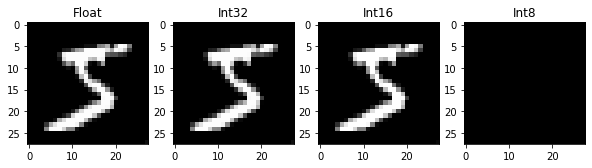

In [73]:
fig1, axs = plt.subplots(1,4,figsize=(10,6))
axs[0].imshow(imgs[0,:,:], cmap="gray")
axs[0].set_title('Float')
axs[1].imshow(imgs_i32[0,:,:], cmap="gray")
axs[1].set_title('Int32')
axs[2].imshow(imgs_i16[0,:,:], cmap="gray")
axs[2].set_title('Int16')
axs[3].imshow(imgs_i8[0,:,:], cmap="gray")
axs[3].set_title('Int8')
plt.plot()

Check the output of quantisised network:



In [74]:
lbls_nn_i32, nn32_activations = nn_lenet_i32.forward_intermediate(x=imgs_i32)
lbls_nn_i32.argmax(axis=1)

array([6])

The output of the network is definitly wrong. Lets check the intermediate layer outputs

In [75]:
nn32_activations

[array([[[[      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0]],
 
         [[      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          [      0],
          

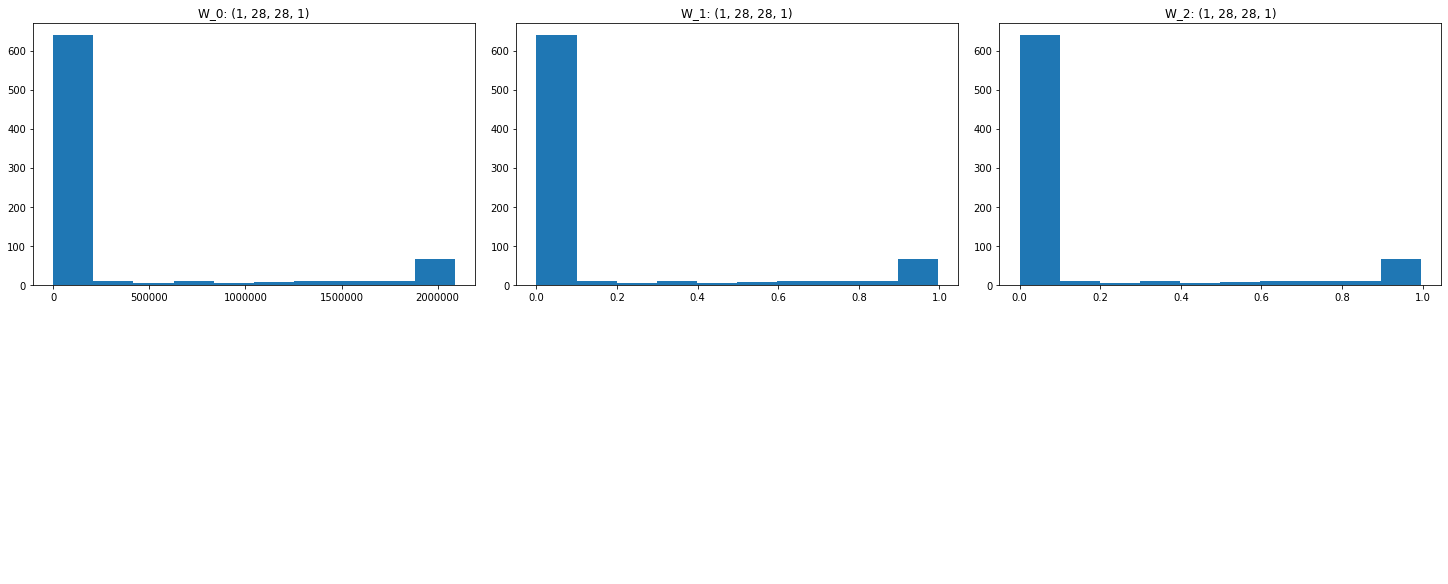

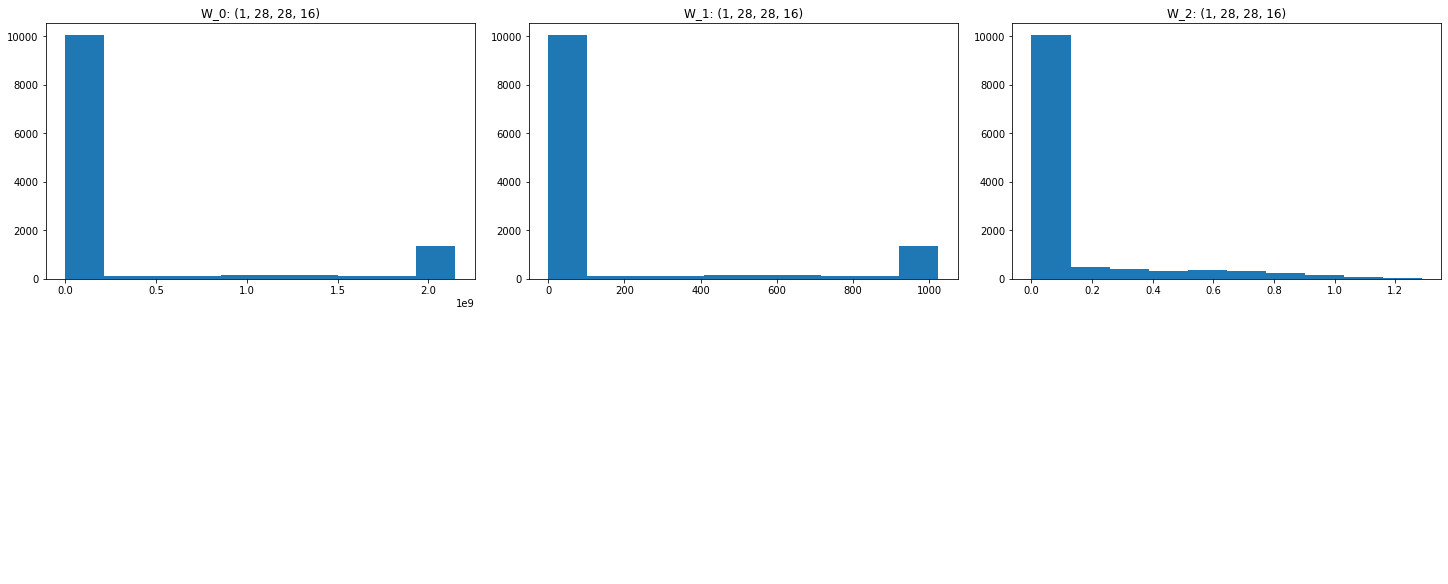

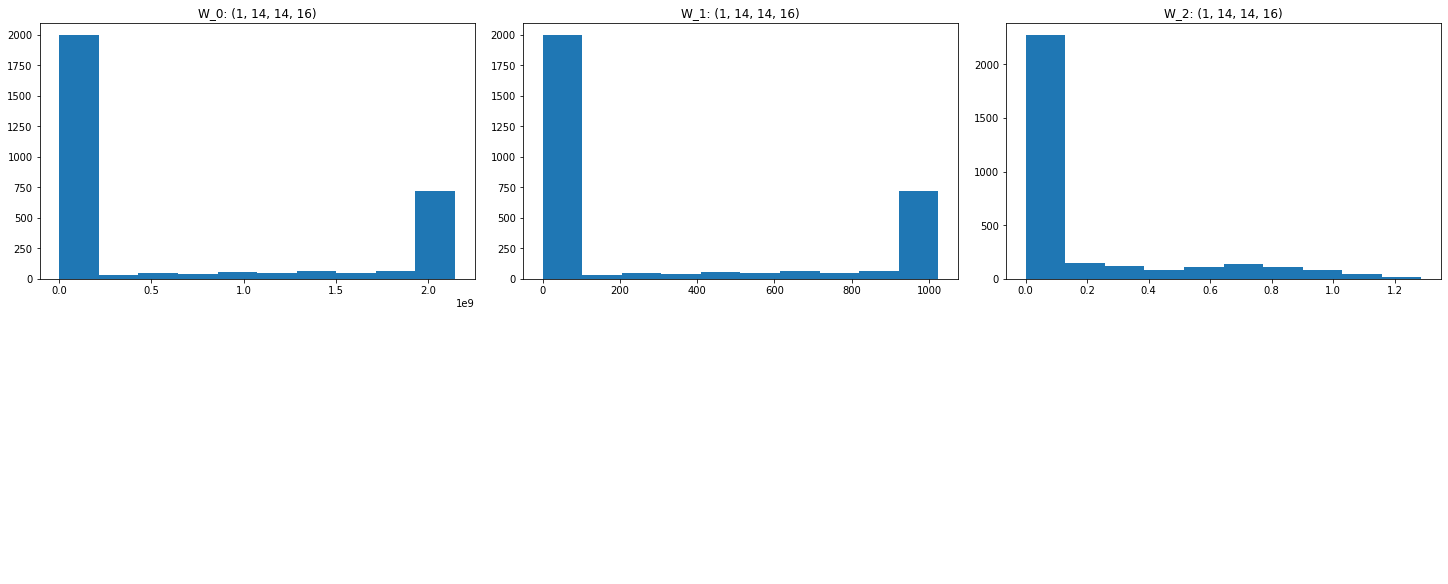

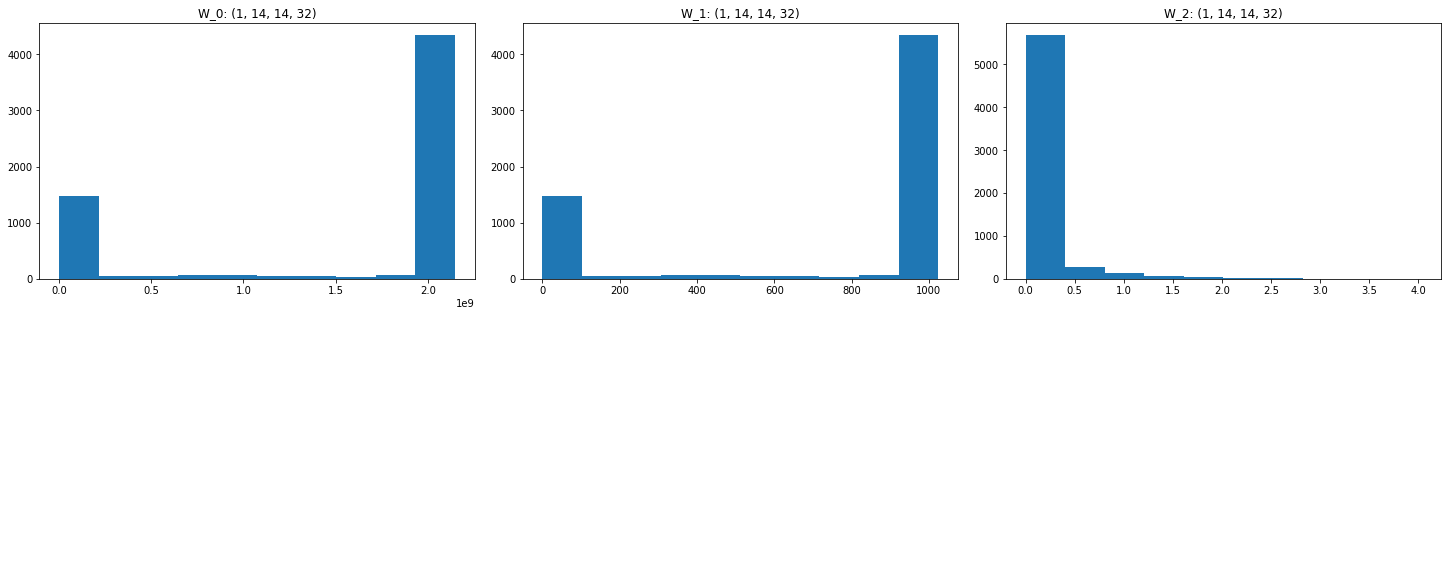

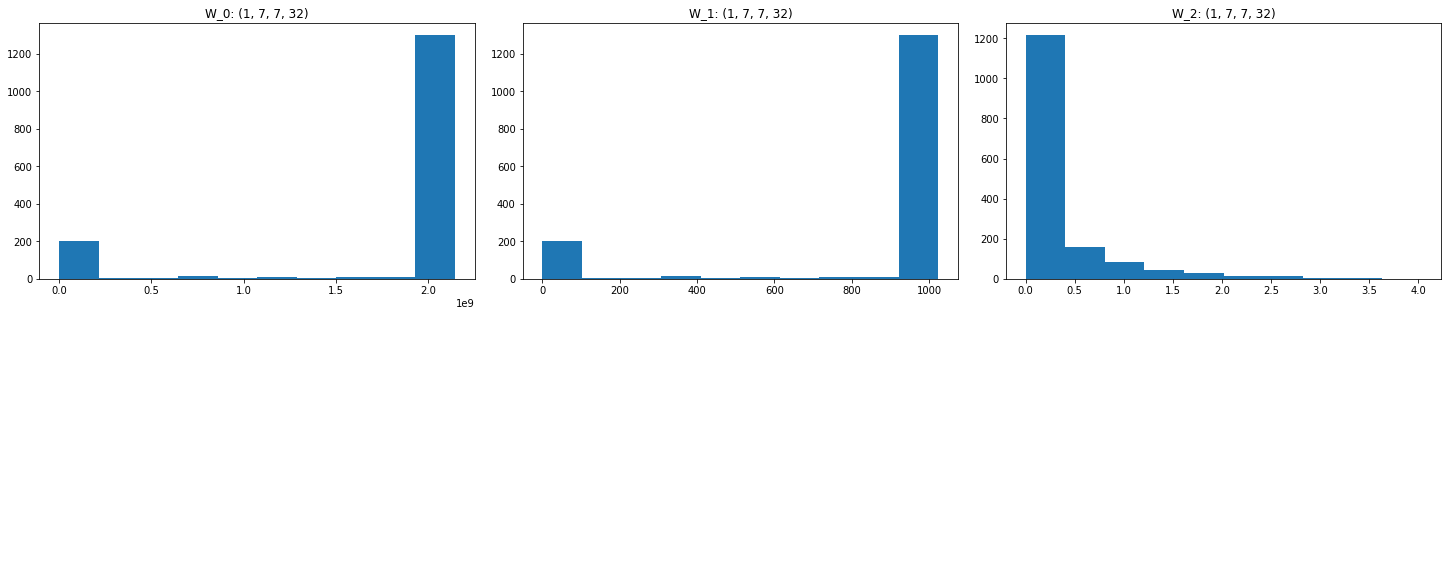

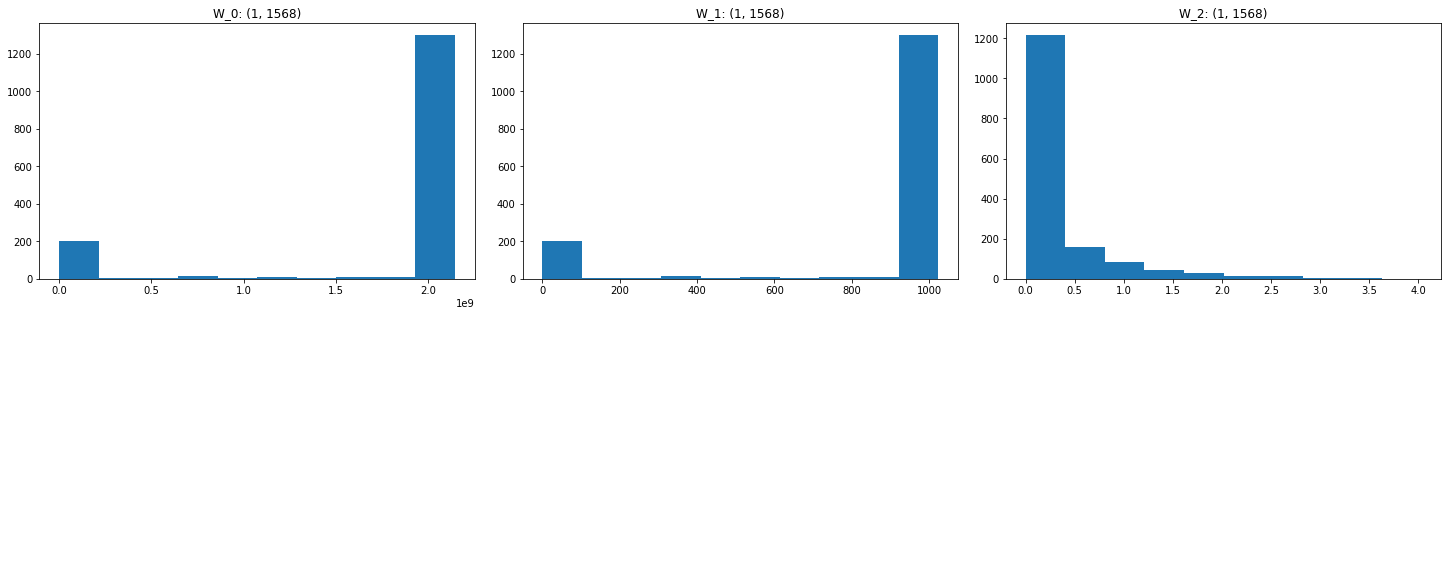

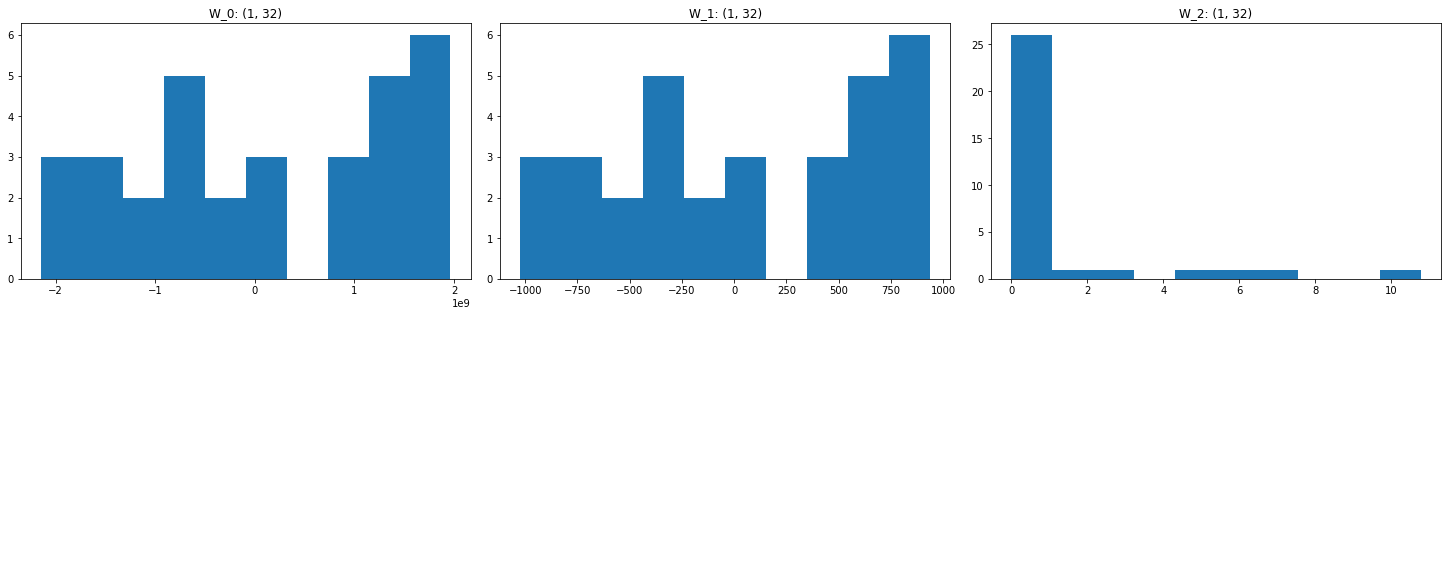

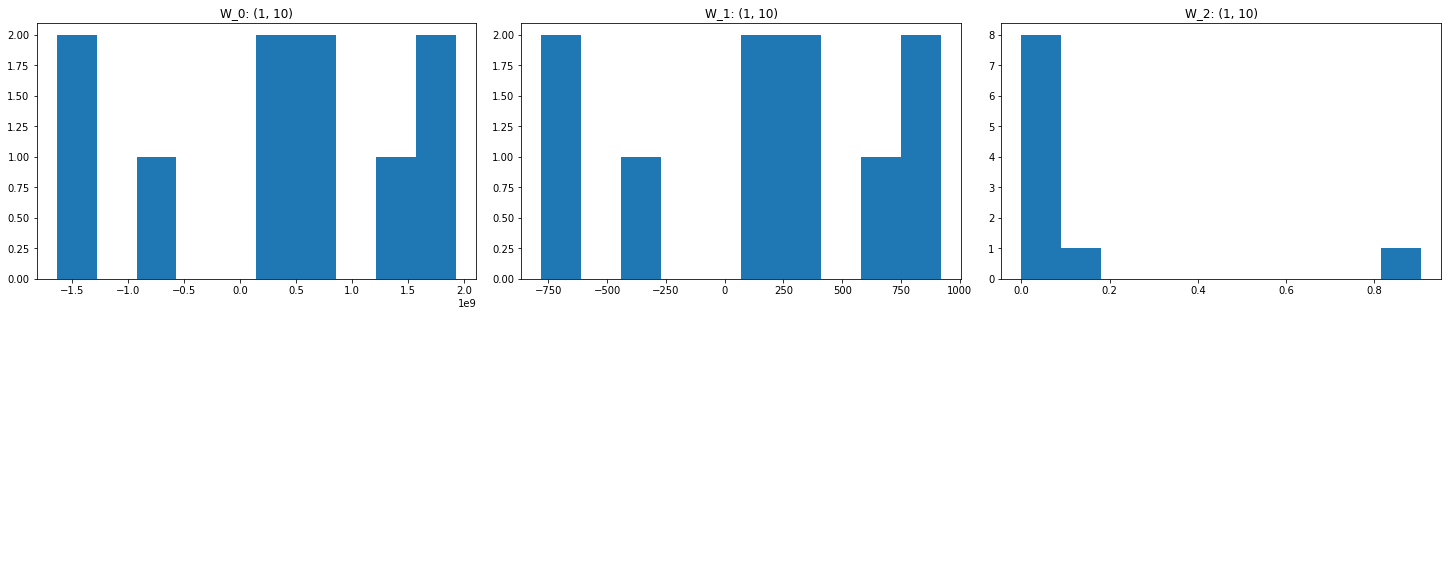

In [79]:
i_activation = 0
for iact, fact in zip(nn32_activations, nnf64_activations):
    # The back to float converted integer value
    dq_iact = nnquant.dequantize_vector(iact, min_value=-INT_MAX_VAL, max_value=INT_MAX_VAL)
    plot_network_parameter_histogram([iact, dq_iact, fact], cols=3, figsize=(20,8))
    plt.savefig(f'activation_hist_layer{i_activation}.png')
    i_activation += 1

## Comparision of the Conv Layers



[]

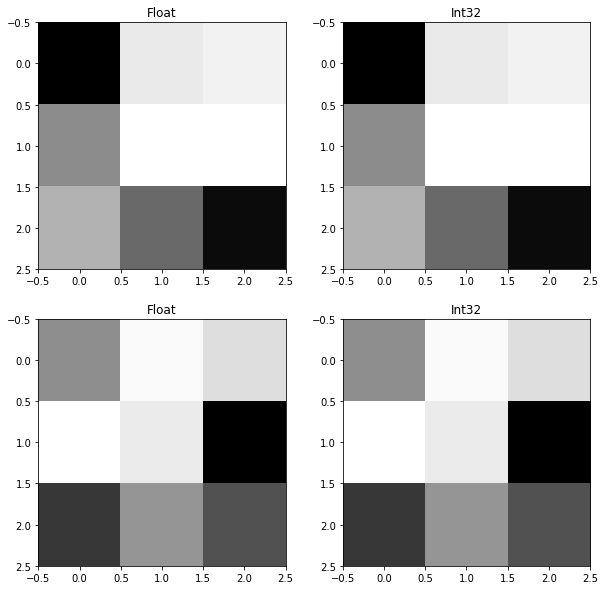

In [98]:
cnv1_kernel_int = nn_lenet_i32.layers[1].kernel
cnv1_kernel_float = nn_lenet_f64.layers[1].kernel


fig1, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(cnv1_kernel_float[:,:,0,0], cmap="gray")
axs[0,0].set_title('Float')

axs[0,1].imshow(cnv1_kernel_int[:,:,0,0], cmap="gray")
axs[0,1].set_title('Int32')
axs[1,0].imshow(cnv1_kernel_float[:,:,0,1], cmap="gray")
axs[1,0].set_title('Float')
axs[1,1].imshow(cnv1_kernel_int[:,:,0,1], cmap="gray")
axs[1,1].set_title('Int32')
plt.plot()

[]

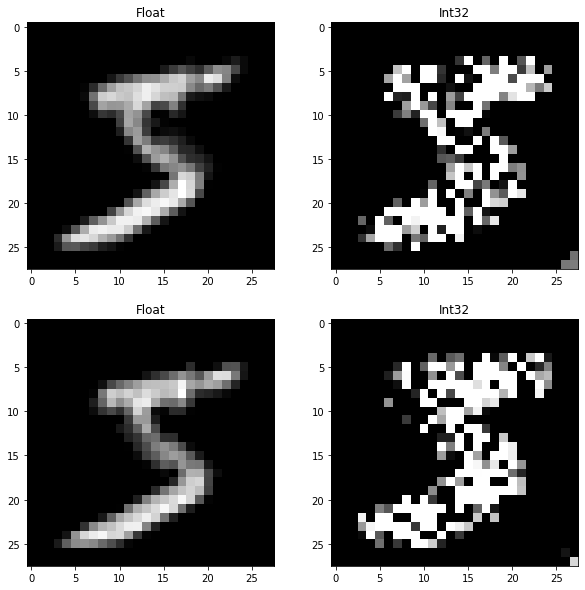

In [97]:
cnv1_out_int = nn32_activations[1]
cnv1_out_float = nnf64_activations[1]


fig1, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(cnv1_out_float[0,:,:,0], cmap="gray")
axs[0,0].set_title('Float')
axs[0,1].imshow(cnv1_out_int[0,:,:,0], cmap="gray")
axs[0,1].set_title('Int32')
axs[1,0].imshow(cnv1_out_float[0,:,:,1], cmap="gray")
axs[1,0].set_title('Float')
axs[1,1].imshow(cnv1_out_int[0,:,:,1], cmap="gray")
axs[1,1].set_title('Int32')
plt.plot()